# MAI643 - Artificial Intelligence in Medicine

Project Assignment 1 - Spring Semester 2024

Student Name:    
Christina Ioanna Saroglaki   
Jianlin Ye 

UCY Email:     
saroglaki.christina-ioanna@ucy.ac.cy    
jye00001@ucy.ac.cy 

## Description 
----
This file contains the source code for the development of the cervical cancer prediction system.

**This does not contain the source code for the preliminary analysis.** The source code for the preliminary analysis is contained in the `pre-processing.ipynb` file.

### Import Libararies

In [40]:
from IPython.display import clear_output

!pip install pyarrow imbalanced-learn

clear_output()

In [41]:
import pandas as pd 
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

np.set_printoptions(formatter={'float':"{:6.5g}".format})

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Overview

As per the authors, the chosen dataset focuses on indicators associated with the diagnosis of cervical cancer, encompassing various features such as demographic information, habits, and medical records​. In more detail, the data was gathered at "Hospital Universitario de Caracas" in Venezuela from a total of 858 patients​.

C. J. Fernandes Kelwin and J. Fernandes, “Cervical cancer (Risk Factors),” UCI Machine 
Learning Repository. 2017.

In [42]:
risk_factor_df = pd.read_csv("risk_factors_cervical_cancer.csv", 
            na_values=["?"])

print("----------------------------------- Information -----------------------------------")
risk_factor_df.info()

----------------------------------- Information -----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)               

# Data pre-processing steps
---
- Re-encoded missing values from "?" to `NaN`
- Handled missing and duplicate values
- Dropped zero variance features
- Removed outliers
- Split data into training, validation and test sets
- Handled target variable imbalance
- Performed dimensionality reduction

## Data cleaning
### Missing Values

First, we needed to find and manage the volume of missing values contained in the dataset.

In [43]:
print("----------------------------------- Missing Values -----------------------------------")
missing_info = risk_factor_df.isnull().sum()
total_nan = missing_info.sum()
total_entries = risk_factor_df.size

# Print total NaN values
if (total_nan == 0):
    print("\nNo NaN values in the dataset.")
else:
    print("\nNaN values found in the dataset.")

    print("\nTotal NaN values in dataset: {}/{}".format(total_nan, total_entries))

    # Sort columns by the number of missing values
    nan_columns = missing_info.sort_values(ascending=False)

    print("\nTop 15 columns with missing values:\n")
    for i, (col, count) in enumerate(nan_columns.head(15).items(), 1):
        print("{:2}. {:35} : {:}".format(i, col, count))

----------------------------------- Missing Values -----------------------------------

NaN values found in the dataset.

Total NaN values in dataset: 3622/30888

Top 15 columns with missing values:

 1. STDs: Time since last diagnosis     : 787
 2. STDs: Time since first diagnosis    : 787
 3. IUD                                 : 117
 4. IUD (years)                         : 117
 5. Hormonal Contraceptives             : 108
 6. Hormonal Contraceptives (years)     : 108
 7. STDs:pelvic inflammatory disease    : 105
 8. STDs:vulvo-perineal condylomatosis  : 105
 9. STDs:HPV                            : 105
10. STDs:Hepatitis B                    : 105
11. STDs:HIV                            : 105
12. STDs:AIDS                           : 105
13. STDs:molluscum contagiosum          : 105
14. STDs:genital herpes                 : 105
15. STDs:syphilis                       : 105


We identified that the features `STDs: Time since first diagnosis` and `STDs: Time since last diagnosis` were filled with NaN values of about 92%. Because of the high percentage, it was impractical to either eliminate the affected observations or fill the missing values with the mean of columns. Consequently, these features were excluded from the dataset.

In [44]:
risk_factor_df.drop(columns=["STDs: Time since first diagnosis", "STDs: Time since last diagnosis"], inplace=True)

To ensure the optimal performance of future models, we also set a **missing value threshold of 10 per row**. Any rows that exceeded this threshold were eliminated from the dataset because we determined they were missing significant information.

In [45]:
# Rows containing NaN values
total_rows = len(risk_factor_df)
nan_rows = risk_factor_df.isna().any(axis=1).tolist().count(True)
print("\nTotal Rows containing NaN values in dataset: {}/{}".format(nan_rows, total_rows))

# Find rows that contain more than 10 NaN values
rows_to_del = risk_factor_df[risk_factor_df.isna().sum(axis=1) > 10].index

print("\nRows containing >10 NaN values: {}/{}".format(len(rows_to_del), total_rows))

# Remove rows
risk_factor_df.drop(rows_to_del, inplace=True)
risk_factor_df.reset_index(drop=True, inplace=True)


Total Rows containing NaN values in dataset: 190/858

Rows containing >10 NaN values: 105/858


For the remaining columns, we managed the missing values depending on the column. In more detail, if the column contained binary values (0,1) then the row containing the missing value was deleted. Otherwise, the missing value was replaced with the mean of the column.

In [46]:
print("--------------------------- Handling Missing Values ---------------------------")
print("----------------------------------- BEFORE -----------------------------------")
print("Number of rows before filling missing values: ", len(risk_factor_df))

# Display the number of missing values before filling
print("\nNumber of missing values per column before filling:")
print(risk_factor_df.isnull().sum())

# Fill missing values depending on the column
for col in risk_factor_df.columns:
    # If the column has more than 3 unique values, fill with mean of the column
    if risk_factor_df[col].nunique() > 3:
        risk_factor_df[col] = risk_factor_df[col].fillna(risk_factor_df[col].median())
    
# Drop rest NaN containing rows
risk_factor_df=risk_factor_df.dropna()
risk_factor_df.reset_index(drop=True, inplace=True)

--------------------------- Handling Missing Values ---------------------------
----------------------------------- BEFORE -----------------------------------
Number of rows before filling missing values:  753

Number of missing values per column before filling:
Age                                    0
Number of sexual partners             14
First sexual intercourse               6
Num of pregnancies                    47
Smokes                                10
Smokes (years)                        10
Smokes (packs/year)                   10
Hormonal Contraceptives               13
Hormonal Contraceptives (years)       13
IUD                                   16
IUD (years)                           16
STDs                                   0
STDs (number)                          0
STDs:condylomatosis                    0
STDs:cervical condylomatosis           0
STDs:vaginal condylomatosis            0
STDs:vulvo-perineal condylomatosis     0
STDs:syphilis                          0

In [47]:
print("\n----------------------------------- AFTER -----------------------------------")
print("Number of rows after filling missing values: ", len(risk_factor_df))

# Display the number of missing values after filling
print("\nNumber of missing values per column after filling:")
print(risk_factor_df.isnull().sum())


----------------------------------- AFTER -----------------------------------
Number of rows after filling missing values:  726

Number of missing values per column after filling:
Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum cont

### Duplicate Rows

Following the missing value analysis, we examined if the dataset contained any duplicate rows and removed them from the dataset.

In [48]:
print("----------------------------------- Duplicate Rows -----------------------------------")
# Check for duplicate rows
duplicate_rows = risk_factor_df.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

if num_duplicates == 0:
    print("No duplicate rows found in the dataset.")
else:
    print(f"Found {num_duplicates} duplicate rows in the dataset.\n")

    # Display the duplicate rows indexes (if any)
    print("Duplicate rows indexes: {}\n".format(risk_factor_df[duplicate_rows].index.values))

    # Removing duplicate rows
    print("----------------------------- Removing Duplicates ----------------------------")
    print("----------------------------------- BEFORE -----------------------------------")
    print("Number of rows before removing duplicates: ", len(risk_factor_df))

    risk_factor_df.drop_duplicates(inplace=True)
    risk_factor_df.reset_index(drop=True, inplace=True)

    print("\n----------------------------------- AFTER -----------------------------------")
    print("Number of rows after removing duplicates: ", len(risk_factor_df))


----------------------------------- Duplicate Rows -----------------------------------
Found 18 duplicate rows in the dataset.

Duplicate rows indexes: [ 63 222 296 332 340 360 364 368 370 377 387 405 441 447 480 484 536 607]

----------------------------- Removing Duplicates ----------------------------
----------------------------------- BEFORE -----------------------------------
Number of rows before removing duplicates:  726

----------------------------------- AFTER -----------------------------------
Number of rows after removing duplicates:  708


### Remove zero variance features
MOving on, we also calculated the mean and standard deviation for each column. Columns with a standard deviation of 0 were omitted from the dataset because they did not add significant variability to the data since they contained the same value for all observations.

In [49]:
mean_df = risk_factor_df.mean()
std_df = risk_factor_df.std()

# Print columns that have a standard deviation 0 (contain only one value)
print("Columns containing 1 value: {}\n".format(std_df[std_df==0].index.values))

risk_factor_df.drop(columns=["STDs:cervical condylomatosis", "STDs:AIDS"], inplace=True)

Columns containing 1 value: ['STDs:cervical condylomatosis' 'STDs:AIDS']



### Remove Outliers

The IQR (Inter Quartile Range) approach is the most commonly used and most trusted approach used in the research field to find outliers in a dataset. We utilised IQR to identify and remove outliers.

In [50]:
# Function finding the unique values of each column in the dataframe
def find_unique_values_df(feat: pd.DataFrame):
    return {col: feat[col].unique() for col in feat}

def find_outliers(col, indices):
    obs = risk_factor_df[col].iloc[indices]
    unique_items, counts = np.unique(obs, return_counts=True)
    unique_items, counts = unique_items[::-1], counts[::-1]

    values_to_delete = unique_items[counts < 2 ]
    return values_to_delete

def delete_outliers(col, to_delete):
    if (to_delete.size != 0):
        rows_to_del = risk_factor_df.loc[risk_factor_df[col].isin(to_delete)].index.values.tolist()

        # Remove rows
        risk_factor_df.drop(rows_to_del, inplace=True)
        risk_factor_df.reset_index(drop=True, inplace=True)

In [51]:
# Unique Values
unique_vals = find_unique_values_df(risk_factor_df)
# Identify non-binary columns
non_binary_cols = [col for col, vals in unique_vals.items() if len(vals) > 2]

for col in non_binary_cols:

    # IQR cannot be applied to columns with median 0
    if (risk_factor_df[col].median() != 0):
        Q3, Q1 = np.percentile(risk_factor_df[col], [75 ,25])
        IQR = Q3-Q1

        upper = Q3+(1.5*IQR)
        lower = Q1-(1.5*IQR)

        print(col)
        print("median: {}, upper fence: {}, lower fence: {}\n".format(risk_factor_df[col].median(), upper, lower))

        #Delete one occurrence observations outside the upper fence as outliers
        upper_to_delete = find_outliers(col, np.where(risk_factor_df[col] > upper)[0])
        delete_outliers(col, upper_to_delete)

        
        #Delete one occurrence observations outside the lower fence as outliers
        lower_to_delete = find_outliers(col, np.where(risk_factor_df[col] < lower)[0])
        delete_outliers(col, lower_to_delete)

Age
median: 26.0, upper fence: 51.0, lower fence: 3.0

Number of sexual partners
median: 2.0, upper fence: 4.5, lower fence: 0.5

First sexual intercourse
median: 17.0, upper fence: 22.5, lower fence: 10.5

Num of pregnancies
median: 2.0, upper fence: 6.0, lower fence: -2.0

Hormonal Contraceptives (years)
median: 0.5, upper fence: 7.5, lower fence: -4.5



In [52]:
print("\nFinal dataset size: {} cols, {} rows".format(risk_factor_df.shape[1], risk_factor_df.shape[0]))


Final dataset size: 32 cols, 697 rows


## Dataset splitting

### Target Variable

As previously stated, the final system will focus on predicting a single target variable. According to the literature, Pap tests primarily serve as preventative medical screenings, while the Schiller and colposcopy examinations are usually coupled with a biopsy to validate the results of the tests. Considering this literature and our prior analysis, we have selected the `Biopsy` feature as the target variable for our system. 

In [53]:
X = risk_factor_df.drop(columns=["Hinselmann", "Schiller", "Citology", "Biopsy"])
y = risk_factor_df["Biopsy"]

X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify = y, 
                                                    shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, 
                                                test_size=0.5,
                                                random_state=42,
                                                stratify = y_temp,
                                                shuffle=True)

## Handling Imbalanced Data
In order to address the imbalance within the target variable, we implemented the **SMOTE-ENN** method. Introduced by Batista et al. (2004), this method combines the ability of SMOTE to generate synthetic data points for the minority class, and ENN (Edited Nearest Neighbor), which eliminates data points from both classes that have a different class from the majority class among their K-Nearest Neighbors.

We opted for SMOTE-ENN over SMOTETomek due to its ability to remove noisy samples, thereby enhancing the quality of the dataset.


In [54]:
smote_enn = SMOTEENN(random_state=42)

x_train_sm, y_train_sm = smote_enn.fit_resample(X_train, y_train)

In [55]:
#Plot
color_1 = [px.colors.qualitative.Prism[0], px.colors.qualitative.Prism[1]]

y_train_counts = y_train.value_counts().reset_index()
y_train_counts.columns = ['Class', 'Count']
y_train_counts['Class'] = y_train_counts['Class'].map({0: 'Healthy', 1: 'Cervical Cancer'})

y_train_sm_counts = y_train_sm.value_counts().reset_index()
y_train_sm_counts.columns = ['Class', 'Count']
y_train_sm_counts['Class'] = y_train_sm_counts['Class'].map({0: 'Healthy', 1: 'Cervical Cancer'})

targ_fig = make_subplots(1, 2, specs=[[{"type":"domain"}, {"type":"domain"}]],
    subplot_titles=["Original Distribution", "Balanced Distribution"])

targ_fig.add_trace(go.Pie(labels=y_train_counts["Class"],
    values=y_train_counts["Count"],
    marker_colors=color_1), 1, 1)

targ_fig.add_trace(go.Pie(labels=y_train_sm_counts["Class"],
    values=y_train_sm_counts["Count"],
    marker_colors=color_1), 1, 2)

targ_fig.update_layout(title_text="Rows Containing NaN Values",
    width=850, height= 400,
    title_x=0.5)

targ_fig.show()

## Data Scaling and Encoding
Scaling and Encoding were only performed in the training set to avoid information leakage.

In [56]:
# Create a StandardScaler object
scaler = StandardScaler()

# Specify the features to be scaled
features_to_scale = ["Smokes (packs/year)", "Hormonal Contraceptives (years)", "IUD (years)"]

# Scale the specified features and add new columns with suffix '_scaled'
x_train_sm[[f"{feature}_scaled" for feature in features_to_scale]] = scaler.fit_transform(x_train_sm[features_to_scale])

# Transform the scaled columns in the validation and test sets as well
X_val[[f"{feature}_scaled" for feature in features_to_scale]] = scaler.transform(X_val[features_to_scale])
X_test[[f"{feature}_scaled" for feature in features_to_scale]] = scaler.transform(X_test[features_to_scale])

#Drop original columns from the training set
x_train_sm.drop(columns=features_to_scale, inplace=True)
X_val.drop(columns=features_to_scale, inplace=True)
X_test.drop(columns=features_to_scale, inplace=True)


In [57]:
# Define age categories, every 5 years as an intervals
age_intervals = [13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88]
labels = list(range(len(age_intervals) - 1))

# Encode the "Age" feature
x_train_sm['Age_encoded'] = pd.cut(x_train_sm['Age'], bins=age_intervals, labels=labels, right=False)
X_val['Age_encoded'] = pd.cut(X_val['Age'], bins=age_intervals, labels=labels, right=False)
X_test['Age_encoded'] = pd.cut(X_test['Age'], bins=age_intervals, labels=labels, right=False)

#Drop original column from the training set
x_train_sm.drop(columns=['Age'], inplace=True)
X_val.drop(columns=['Age'], inplace=True)
X_test.drop(columns=['Age'], inplace=True)

## Dimensionality Reduction - PCA

In [58]:
# Scale data
minMaxScaler = MinMaxScaler()
x_train_rescaled = minMaxScaler.fit_transform(x_train_sm)
x_val_rescaled = minMaxScaler.transform(X_val)
x_test_rescaled = minMaxScaler.transform(X_test)

# 95% of variance
pca = PCA(n_components=11)
x_train_reduced = pca.fit_transform(x_train_rescaled)
x_val_reduced = pca.transform(x_val_rescaled)
x_test_reduced = pca.transform(x_test_rescaled)

In [59]:
print("Train:", x_train_reduced.shape, "Validation:", x_val_reduced.shape, "Test:", x_test_reduced.shape)

Train: (650, 11) Validation: (115, 11) Test: (116, 11)


# Model Development
---
For the prediction models we selected to utilize the models of Support Vector Machine (SVM) and the ensemble method of Random Forests.

## Preparation before Traning
---

**The goal of the finetune function is to search for the best hyperparameters of a classifier using GridSearchCV and RandomizedSearchCV. The function must print and return the best parameters.** 


**Input:**  
•clf: The classifier.   
•grid_param: The parameters to investigate during grid search.  
•rand_param: The parameter distribution to investigate during random search.    
•X,Y: The training sets. 

**Output:**     
•grid_best: Best parameters discovered from grid search.    
•rand_best: Best parameters discovered from random search.

**Important settings:**     
•Use only 2 folds for cross-validation  
•Score models based on their AUC    
•Sample only 50 parameter settings when using RandomizedSearchCV    
The goal of the fit_and_evaluate function is to fit a classifier (clf) to the data and return the false positive rate (fpr), true positive rate (tpr) and the area-under-the-curve (auc).

In [60]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

def finetune(clf, grid_param, rand_param, X, Y):
    # GridSearchCV
    grid_search = GridSearchCV(clf, grid_param, cv=2, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X, Y)
    grid_best = grid_search.best_params_

    # RandomizedSearchCV
    rand_search = RandomizedSearchCV(clf, rand_param, n_iter=50, cv=2, scoring='roc_auc', random_state=0, n_jobs=-1)
    rand_search.fit(X, Y)
    rand_best = rand_search.best_params_

    # Print best parameters in a cleaner format
    print("\n\tGridSearch Best Parameters:")
    for param, value in grid_best.items():
        print(f"\t\t{param}: {value}")

    print("\n\tRandomizedSearch Best Parameters:")
    for param, value in rand_best.items():
        print(f"\t\t{param}: {value}")
    print("\n" + "-"*50)

    return grid_best, rand_best

def fit_and_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)
    auc = metrics.roc_auc_score(y_test, pred_proba)
    return fpr, tpr, auc

Investigated parameters:

(RF)    
n_estimators: Number of trees in the forest.    
max_features: The number of features to consider when looking for the best
split.

RF: Parameters like `max_features` can control the model's complexity and prevent overfitting. `n_estimators` will influence the ensemble's power.

In [61]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest (RF)
clf_rf = RandomForestClassifier(random_state=0)
grid_param_rf = {'n_estimators': [10,50,100], 'max_features': [None, 10, 20]}
rand_param_rf = {'n_estimators': np.arange(10, 100, 10), 'max_features': [None, 10, 20]}

print("\nHyperparameters for RF:")
finetune(clf_rf, grid_param_rf, rand_param_rf, x_train_reduced, y_train_sm)


Hyperparameters for RF:


c:\ProgramData\miniconda3\envs\mai643\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning:

The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.




	GridSearch Best Parameters:
		max_features: 10
		n_estimators: 100

	RandomizedSearch Best Parameters:
		n_estimators: 80
		max_features: 10

--------------------------------------------------


({'max_features': 10, 'n_estimators': 100},
 {'n_estimators': 80, 'max_features': 10})

**Grid search** experiment with all pre-defined combinations of hyperparameters.

**Random search** experiment with hyperparameter values randomly sampled from pre-defined distributions.

Since Grid search will test all combinations, it will find the best hyperparameter combinations. However, Random search will give a good enough combination of hyperparameters for a short period of time. Both methods will find the best hyperparameter combinations if enough time passes.

**Trade-off**:The trade-off between grid and random search revolves around computation time versus the assurance of finding the best parameters. While grid search provides a systematic approach and guarantees the best combination within the grid, it's often time-consuming, especially with a large hyperparameter space. On the other hand, random search doesn't assure the best combination but can reach a good set of parameters much faster.

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


# Define the best parameters from grid and random search

best_grid_rf = {'n_estimators': 100, 'max_features': 10}
best_rand_rf = {'n_estimators': 80, 'max_features': 10}

# Function to fit and evaluate for a given setting
def evaluate_model_setting(clf, X_train, y_train, X_test, y_test, param=None):
    if param:
        clf.set_params(**param)
    fpr, tpr, auc_score = fit_and_evaluate(clf, X_train, y_train, X_test, y_test)
    return auc_score

# Evaluate each model for different settings
for model, grid_param, rand_param in zip(
    [RandomForestClassifier(random_state=0)],
    [best_grid_rf],
    [best_rand_rf]
):

    # a. Default settings
    auc_default = evaluate_model_setting(model, x_train_reduced, y_train_sm, x_test_reduced, y_test)
    # b. GridSearch best parameters
    auc_grid = evaluate_model_setting(model, x_train_reduced, y_train_sm, x_test_reduced, y_test, grid_param)
    # c. RandomSearch best parameters
    auc_rand = evaluate_model_setting(model, x_train_reduced, y_train_sm, x_test_reduced, y_test, rand_param)

    print(f"Model {model.__class__.__name__}:")
    print(f"AUC (Default): {auc_default}")
    print(f"AUC (GridSearch Best Params): {auc_grid}")
    print(f"AUC (RandomSearch Best Params): {auc_rand}")
    print("------------------------------------------------")

Model RandomForestClassifier:
AUC (Default): 0.5856481481481481
AUC (GridSearch Best Params): 0.6273148148148148
AUC (RandomSearch Best Params): 0.6296296296296297
------------------------------------------------


# Model Evaluation
---

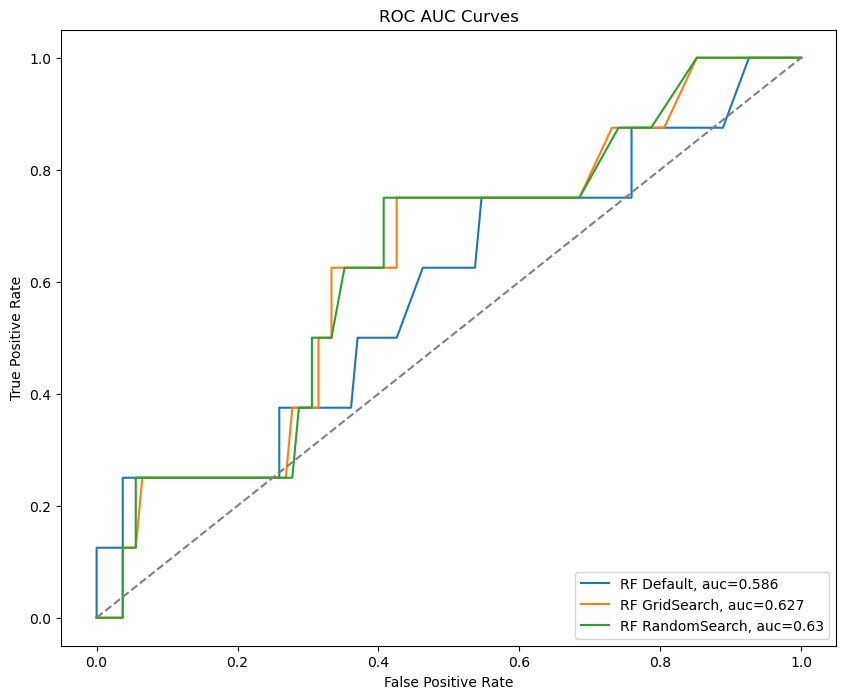

In [66]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Set up the plotting
plt.figure(figsize=(10, 8))

# Lists to store classifier details
clfs = [
    (RandomForestClassifier(random_state=0), 'RF Default'),
    (RandomForestClassifier(n_estimators=100, max_features=10, random_state=0), 'RF GridSearch'),
    (RandomForestClassifier(n_estimators=80, max_features=10, random_state=0), 'RF RandomSearch'),
]

# Plot each classifier's ROC curve
for clf, label in clfs:
    fpr, tpr, auc = fit_and_evaluate(clf, x_train_reduced, y_train_sm, x_test_reduced, y_test)
    plt.plot(fpr, tpr, label=f"{label}, auc={round(auc, 3)}")

# Add labels, legend, and show the plot
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves')
plt.legend(loc='lower right')
plt.show()

### Choose the best performing hyperparameters for RF
---

RF: `n_estimators`: 90, `max_features`: 10

GridSearchCV recommends using 100 trees, while RandomisedSearchCV recommends using 80 trees. Both methods are in agreement on `max_features`: 10. Given that the recommended values for both methods are close and no additional performance metrics are provided. an intermediate value can be chosen: `n_estimators`: 90 and `max_features`: 10.

**Measure and plot the time it takes to train and evaluate each of the following classifiers:**     
•RF (discovered hyperparameters)    
•Support Vector Classifier (SVC – Scikit-Learn) (default settings)